In [160]:
from facenet_pytorch import MTCNN, InceptionResnetV1
import torch
import cv2
import time
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import copy
import os
from PIL import Image, ImageDraw, ImageFont

%matplotlib inline

In [161]:
# check use gpu or cpu device
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Running on device: {}'.format(device))


Running on device: cuda:0


In [162]:
# initial model
mtcnn = MTCNN(keep_all=True, device=device)
resnet = InceptionResnetV1(pretrained='vggface2').eval().to(device)


(1152, 2048, 3)


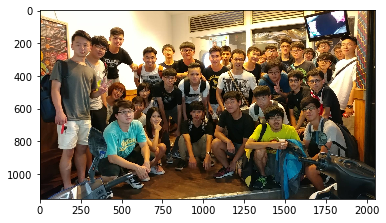

In [163]:
# read frame
frame = cv2.imread('./img/class.jpg')

frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

print(frame.shape)
plt.imshow(frame)

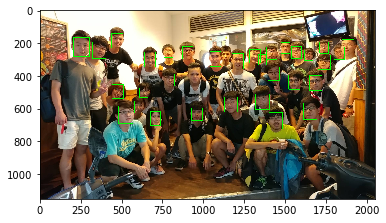

In [164]:
# detect faces
def detect(frame):
    boxes, probs = mtcnn.detect(frame)

    boxes = boxes.astype(int)
    
    return boxes

boxes = detect(frame)
# print(boxes)

# draw boxes
def draw_boxes(frame, boxes):
    frame = copy.deepcopy(frame)
    for box in boxes:
        (x1,y1,x2,y2) = box
        cv2.rectangle(frame, (x1, y1), (x2, y2), (0,255,0), 2)

    return frame
    
frame = draw_boxes(frame, boxes)
plt.imshow(frame)
frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
cv2.imwrite('0.jpg',frame)
frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

In [165]:
# extract face
def extract(frame, boxes):
    faces = []
    for box in boxes:
        (x1,y1,x2,y2) = box

        face = frame[y1:y2, x1:x2]

        face = cv2.resize(face, (160, 160))

        face = np.array(face)
        
        faces.append(face)
    
    return faces

faces = extract(frame, boxes)
print(len(faces))

34


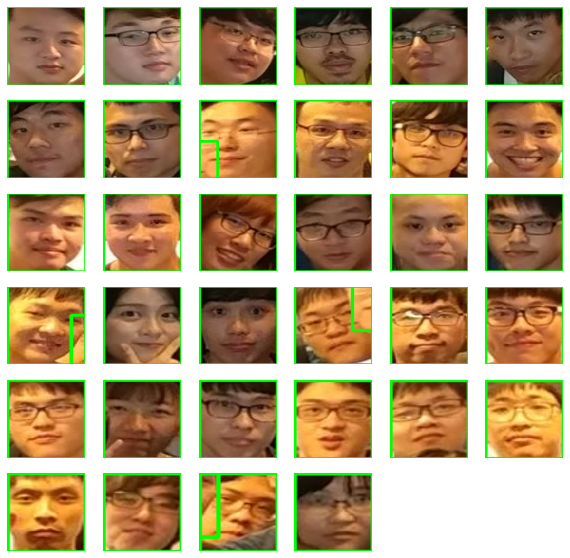

In [166]:
plt.figure(num='faces',figsize=(10,10)) 

for i,face in enumerate(faces):
    plt.subplot(6,6,i+1)                            
    plt.axis('off')  
    plt.imshow(face)
plt.show()

(160, 160, 3)


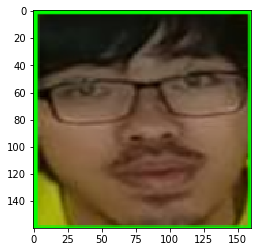

In [167]:
print(faces[3].shape)
plt.imshow(faces[3])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


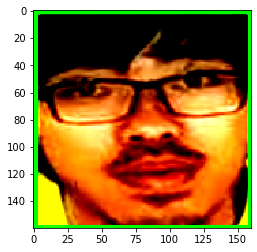

In [168]:
# pre_whiten
def pre_whiten(faces):
    axis = (1, 2, 3)
    size = faces[0].size

    mean = np.mean(faces, axis=axis, keepdims=True)
    std = np.std(faces, axis=axis, keepdims=True)
    std_adj = np.maximum(std, 1.0 / np.sqrt(size))
    faces = (faces - mean) / std_adj

    return faces

whiten_faces = pre_whiten(faces)
plt.imshow(whiten_faces[3])

In [169]:
# transform input shape and type
def transform_inp_faces(faces):
    
    faces = np.transpose(faces, (0,3,1,2))

    faces = torch.tensor(faces)
    
    faces = faces.type(torch.FloatTensor)
    
    faces = torch.stack(tuple(face for face in faces)).to(device)
    
    return faces

inp_faces = transform_inp_faces(whiten_faces)
print(inp_faces.shape)
print(inp_faces.type())

torch.Size([34, 3, 160, 160])
torch.cuda.FloatTensor


In [170]:
def l2_normalize(x, axis=-1, epsilon=1e-10):
    x = x.numpy()
    y = (x / np.sqrt(np.maximum(np.sum(np.square(x), axis=axis, keepdims=True), epsilon)))
    return torch.tensor(y)


In [171]:
# embedding
def embedding(faces):
    t = time.time()
    embeddings = resnet(faces).detach().cpu()
    t1 = time.time()
    print("embed time:",t1-t)
    embeddings = l2_normalize(embeddings)
    return embeddings

embeddings = embedding(inp_faces)
print(embeddings.shape)
print(embeddings)

embed time: 0.11002421379089355
torch.Size([34, 512])
tensor([[ 0.0038,  0.0301, -0.0425,  ..., -0.0504,  0.0153,  0.0287],
        [ 0.0097,  0.0224, -0.0455,  ..., -0.0639,  0.0028, -0.0031],
        [ 0.0308, -0.0346, -0.0801,  ..., -0.0270, -0.0081,  0.0127],
        ...,
        [-0.0208, -0.0186, -0.0465,  ...,  0.0132,  0.0834, -0.0018],
        [ 0.0027, -0.0509, -0.0312,  ..., -0.0487,  0.0367, -0.0561],
        [ 0.0467,  0.0044, -0.0609,  ..., -0.0055,  0.0661,  0.0222]])


鐘


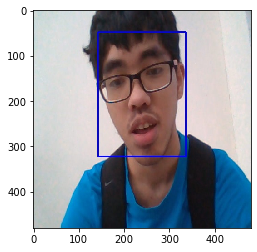

In [172]:
# build training dataset
train_imgs = []
train_names = []
    
src_dir = './img/train/'
dirs = os.listdir(src_dir)

for name in dirs:
    img_dir = src_dir + '/' + name
    for img_name in os.listdir(img_dir):
        img = cv2.imdecode(np.fromfile(img_dir + '/' + img_name, dtype=np.uint8), cv2.IMREAD_UNCHANGED)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
        train_names.append(name)
        train_imgs.append(img)
    
print(train_names[-3])
plt.imshow(train_imgs[-3])

In [173]:
# build database
db_face_dict = {}

for name, img in zip(train_names,train_imgs):
    boxes = detect(img)
    faces = extract(img, boxes)
    white_faces = pre_whiten(faces)
    inp_faces = transform_inp_faces(white_faces)
    embeddings = embedding(inp_faces)
    db_face_dict[name] = embeddings

embed time: 0.05301046371459961
embed time: 0.05301189422607422
embed time: 0.05301189422607422
embed time: 0.053011417388916016
embed time: 0.05501198768615723
embed time: 0.05501198768615723
embed time: 0.05601310729980469
embed time: 0.053012847900390625
embed time: 0.05501270294189453
embed time: 0.053011417388916016
embed time: 0.05401158332824707
embed time: 0.05401158332824707
embed time: 0.05401182174682617
embed time: 0.05401253700256348
embed time: 0.06101417541503906
embed time: 0.05401206016540527


In [174]:
def matching(target_embedings,db_face_dict):
    tg_names = []
    
    for tg_emb in target_embedings:
        min_dist = 0.9
        matching_name = "unknow"
        for name,db_embs in db_face_dict.items():
            for db_emb in db_embs: 
                dist = (tg_emb - db_emb).norm().item()
                if dist < min_dist:
                    min_dist = dist
                    matching_name = name
                    
        tg_names.append(matching_name)
    
    return tg_names

embed time: 0.10202264785766602


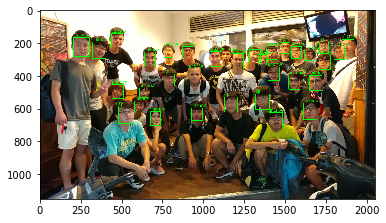

In [175]:
# recognize face from test frame
def recognize(frame):
    boxes = detect(frame)
    faces = extract(frame, boxes)
    white_faces = pre_whiten(faces)
    inp_faces = transform_inp_faces(white_faces)
    embeddings = embedding(inp_faces)
    names = matching(embeddings,db_face_dict)
    
    return names, embeddings, boxes

test_frame = cv2.imread('./img/class.jpg')
test_frame = cv2.cvtColor(test_frame, cv2.COLOR_BGR2RGB)
test_names, test_embeddings, test_boxes = recognize(test_frame)

# draw boxes and names
def draw_boxes_names(frame,boxes,names):
    frame = copy.deepcopy(frame)
    for box, name in zip(boxes, names):
        (x1,y1,x2,y2) = box
        frame = draw_text(frame, name, (x1, y1-30),(0,255,0))
        frame = cv2.rectangle(frame, (x1, y1), (x2, y2), (0,255,0), 2)
    
    return frame
    
# draw chinese text
def draw_text(frame, text, location, color):
    img = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    draw = ImageDraw.Draw(img)
    font = ImageFont.truetype("./font/kaiu.ttf", 30, encoding="utf-8")
    draw.text(location, text, color, font=font)
    frame = cv2.cvtColor(np.asarray(img), cv2.COLOR_RGB2BGR)
    return frame
    
frame = draw_boxes_names(test_frame, test_boxes, test_names)
plt.imshow(frame)
frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
cv2.imwrite('1.jpg',frame)
frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)